<a href="https://colab.research.google.com/github/denizstij/Bitgrit_NFT_Price_Prediction/blob/main/Bitgrit_NFT_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [251]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [252]:
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from catboost import Pool, CatBoostRegressor
import lightgbm as lgb

In [253]:
pd.set_option('display.width', 1000)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [254]:
dataset_path='/content/drive/MyDrive/Colab Notebooks/BritGritNFTPrices/dataset/'


In [255]:
def seed_everything(seed=55):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [256]:
MY_SEED=42
seed_everything(MY_SEED)

In [257]:
df_cols=pd.read_csv(dataset_path+'collections.csv')
df_cols_stats=pd.read_csv(dataset_path+'collections_twitter_stats.csv')
df_all_train=pd.read_csv(dataset_path+'nfts_train.csv')
df_submission=pd.read_csv(dataset_path+'submission_format.csv')
df_nfts_predict=pd.read_csv(dataset_path+'nfts_predict.csv')

In [258]:
df_cols['creation_date']=df_cols['creation_date'].map(lambda x: np.int32(x.replace('-','')))
df_cols['verification_status']=df_cols['verification_status'].astype(str)
df_cols['contract_type']=df_cols['contract_type'].astype(str)

df_all_train['last_sale_date']=df_all_train['last_sale_date'].map(lambda x: np.int32(x.replace('-','')))
df_nfts_predict['last_sale_date']=df_nfts_predict['last_sale_date'].map(lambda x: np.int32(x.replace('-','')))

In [259]:
df_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           48 non-null     int64  
 1   collection_id        48 non-null     int64  
 2   total_supply         48 non-null     int64  
 3   creation_date        48 non-null     int32  
 4   verification_status  48 non-null     object 
 5   n_of_traits          48 non-null     int64  
 6   contract_type        48 non-null     object 
 7   seller_fees          46 non-null     float64
 8   platform_fees        48 non-null     int64  
 9   openrarity_enabled   48 non-null     bool   
 10  has_website          48 non-null     bool   
 11  has_own_twitter      48 non-null     bool   
 12  has_discord          48 non-null     bool   
 13  has_medium           48 non-null     bool   
dtypes: bool(5), float64(1), int32(1), int64(5), object(2)
memory usage: 3.5+ KB


In [260]:
df_cols.describe()

,Unnamed: 0,collection_id,total_supply,creation_date,n_of_traits,seller_fees,platform_fees
count,48.00,48.000000,48.000000,48.000000,48.000000,46.000000,48.0
mean,23.50,30.333333,10760.979167,202155.729167,12.083333,711.956522,250.0
std,14.00,18.062932,9524.450152,49.038734,11.741603,243.626486,0.0
min,0.00,0.000000,1.000000,202101.000000,0.000000,200.000000,250.0
25%,11.75,14.750000,5541.000000,202108.000000,8.000000,500.000000,250.0
50%,23.50,30.500000,9555.000000,202156.500000,9.500000,750.000000,250.0
75%,35.25,45.250000,10000.000000,202204.000000,14.000000,900.000000,250.0
max,47.00,60.000000,58351.000000,202207.000000,80.000000,1000.000000,250.0


In [261]:
df_cols_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         48 non-null     int64  
 1   collection_id      48 non-null     int64  
 2   n_tweets_in_range  48 non-null     int64  
 3   avg_likes          48 non-null     float64
 4   avg_replies        48 non-null     float64
 5   avg_retweets       48 non-null     float64
 6   min_likes          48 non-null     int64  
 7   min_replies        48 non-null     int64  
 8   min_retweets       48 non-null     int64  
 9   max_likes          48 non-null     int64  
 10  max_replies        48 non-null     int64  
 11  max_retweets       48 non-null     int64  
dtypes: float64(3), int64(9)
memory usage: 4.6 KB


In [262]:
df_cols_stats.describe()

,Unnamed: 0,collection_id,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,23.50,30.333333,43.250000,106.612882,21.821623,52.061582,20.458333,3.916667,8.291667,331.020833,98.041667,208.895833
std,14.00,18.062932,120.698058,188.034103,55.518648,91.257491,54.476604,10.771976,13.639677,786.673646,373.930586,468.414857
min,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.75,14.750000,4.750000,7.423289,0.887821,2.913973,0.000000,0.000000,0.000000,18.750000,6.000000,12.000000
50%,23.50,30.500000,11.500000,13.500000,4.114286,11.384211,0.000000,0.000000,1.000000,82.000000,17.500000,52.500000
75%,35.25,45.250000,26.000000,90.295455,9.111111,64.418280,3.750000,0.500000,7.500000,300.500000,70.250000,173.250000
max,47.00,60.000000,668.000000,707.875000,353.400000,442.000000,236.000000,52.000000,46.000000,5079.000000,2601.000000,2990.000000


In [263]:
df_all_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309910 entries, 0 to 309909
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         309910 non-null  int64  
 1   nft_id               309910 non-null  int64  
 2   collection_id        309910 non-null  int64  
 3   rarity_score         309910 non-null  float64
 4   openrarity_score     80480 non-null   float64
 5   openrarity_rank      80480 non-null   float64
 6   openrarity_max_rank  80480 non-null   float64
 7   last_sale_date       309910 non-null  int32  
 8   last_sale_price      309910 non-null  float64
dtypes: float64(5), int32(1), int64(3)
memory usage: 20.1 MB


In [264]:
df_nfts_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181214 entries, 0 to 181213
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         181214 non-null  int64  
 1   nft_id               181214 non-null  int64  
 2   collection_id        181214 non-null  int64  
 3   rarity_score         181214 non-null  float64
 4   openrarity_score     38626 non-null   float64
 5   openrarity_rank      38626 non-null   float64
 6   openrarity_max_rank  38626 non-null   float64
 7   last_sale_date       181214 non-null  int32  
dtypes: float64(4), int32(1), int64(3)
memory usage: 10.4 MB


In [265]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_index     50 non-null     int64  
 1   last_sale_price  50 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 928.0 bytes


In [266]:
set(df_nfts_predict.collection_id.values).intersection(set(df_all_train.collection_id.values))

set()

In [267]:
df_submission.describe()

,global_index,last_sale_price
count,50.00000,50.000000
mean,24.50000,0.617073
std,14.57738,0.600778
min,0.00000,0.022996
25%,12.25000,0.205264
50%,24.50000,0.338147
75%,36.75000,0.920657
max,49.00000,2.266743


In [268]:
df_nfts_predict

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date
0,0,0,29,176.364208,NaN,NaN,NaN,202206
1,1,1,29,207.209228,NaN,NaN,NaN,202205
2,2,2,29,157.293414,NaN,NaN,NaN,202210
3,3,3,29,173.372185,NaN,NaN,NaN,202206
4,4,4,29,190.077584,NaN,NaN,NaN,202206
...,...,...,...,...,...,...,...,...
181209,618137,7140,42,134.963415,NaN,NaN,NaN,202104
181210,618138,7141,42,128.686047,NaN,NaN,NaN,202104
181211,618139,7142,42,22134.000000,NaN,NaN,NaN,202104
181212,618140,7143,42,22134.000000,NaN,NaN,NaN,202104


In [269]:
df_nfts_predict.describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date
count,181214.000000,181214.000000,181214.000000,181214.000000,38626.000000,38626.000000,38626.000000,181214.000000
mean,309791.155888,11445.662471,28.762866,232.415184,1.000000,4372.867628,8741.760731,202204.358532
std,167228.382814,11585.749965,15.321820,1392.046522,0.159457,2857.568048,2300.558399,17.554032
min,0.000000,0.000000,2.000000,0.000000,0.601661,1.000000,3332.000000,202102.000000
25%,231959.250000,3235.250000,22.000000,129.334538,0.880993,1925.000000,9854.000000,202206.000000
50%,287356.500000,7108.500000,35.000000,178.813158,0.982769,3989.000000,9999.000000,202208.000000
75%,459554.750000,16220.000000,39.000000,263.697190,1.086070,6767.000000,10000.000000,202209.000000
max,618141.000000,48256.000000,53.000000,152922.000000,2.561688,10000.000000,10000.000000,202211.000000


In [270]:
df_all_train.describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,309910.000000,309910.000000,309910.000000,309910.000000,80480.000000,80480.000000,80480.000000,309910.000000,3.099100e+05
mean,317003.207947,6738.162024,30.507160,1437.092531,1.000000,5630.164737,11255.829672,202192.401129,2.162269e+00
std,173138.765569,5977.542096,18.331668,4303.585892,0.152825,3812.126968,3452.713804,34.436556,1.275132e+01
min,21928.000000,0.000000,0.000000,1.000000,0.626738,1.000000,5555.000000,202103.000000,6.485360e-08
25%,174892.250000,2453.000000,13.000000,106.587184,0.906820,2515.750000,9928.000000,202202.000000,4.077085e-03
50%,341467.500000,5138.000000,34.000000,170.797030,0.978289,5030.000000,10000.000000,202207.000000,8.103344e-03
75%,493626.750000,8720.750000,46.000000,289.614129,1.059866,8207.250000,15000.000000,202209.000000,3.252062e-01
max,590227.000000,29898.000000,60.000000,90354.072248,3.663833,15555.000000,15555.000000,202211.000000,1.024002e+03


# features
- add mean sales by year (maybe even month)
- ratio of  openrarity_max_rank/ openrarity_rank

In [316]:
df_all_train.groupby('collection_id')['collection_id'].count()

collection_id
0      6501
1     15000
4      9000
6      9602
7     10000
8      9667
13    23091
14     6969
15     7902
18    10000
19     1000
23     9998
24     2498
25     3997
26    10000
30     5022
31    10000
34     5555
36    24154
37     8888
38     5555
43     7751
44    10000
45     8888
46    29899
48     4582
49        1
50     9999
51     5080
54     9928
57     3900
58    15555
59     9508
60      420
Name: collection_id, dtype: int64

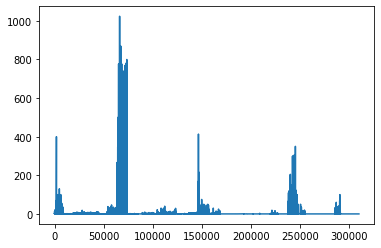

In [271]:
df_all_train.last_sale_price.plot()

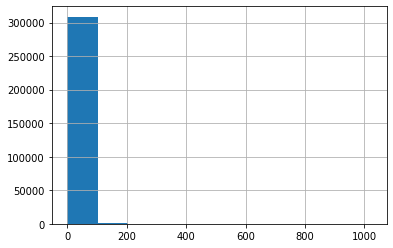

In [309]:
df_all_train.last_sale_price.hist()

In [312]:
df_all_train[df_all_train.collection_id.isin([49,0,38,37,59,19,26])].describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,41453.000000,41453.000000,41453.000000,41453.000000,14443.000000,14443.00000,14443.000000,41453.000000,4.145300e+04
mean,293070.699009,4142.983403,33.289919,140.056423,1.000000,3801.52586,7582.076923,202199.045521,8.104070e-01
std,170076.589033,2650.743844,18.684191,233.573074,0.132693,2384.36402,1602.600498,26.797274,6.423811e+00
min,21928.000000,0.000000,0.000000,1.000000,0.770374,1.00000,5555.000000,202104.000000,1.261076e-07
25%,175071.000000,1872.000000,26.000000,52.442926,0.931205,1804.50000,5555.000000,202205.000000,4.547653e-03
50%,215432.000000,3945.000000,37.000000,108.716551,0.990835,3611.00000,8849.000000,202207.000000,9.035782e-03
75%,322712.000000,6133.000000,38.000000,161.446023,1.050099,5416.50000,8849.000000,202209.000000,3.508993e-01
max,562664.000000,9999.000000,59.000000,9793.201352,3.663833,8849.00000,8849.000000,202211.000000,4.134943e+02


In [314]:
df_all_train[~df_all_train.collection_id.isin([49,0,38,37,59,19,26])].describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,268457.000000,268457.000000,268457.000000,268457.000000,66037.000000,66037.000000,66037.000000,268457.000000,2.684570e+05
mean,320698.676097,7138.888917,30.077469,1637.370556,1.000000,6030.107667,12059.318791,202191.375155,2.371013e+00
std,173312.800242,6242.022048,18.238862,4590.468484,0.156885,3946.652814,3220.157346,35.358747,1.345383e+01
min,32621.000000,0.000000,1.000000,6.086957,0.626738,1.000000,5555.000000,202103.000000,6.485360e-08
25%,126682.000000,2567.000000,13.000000,115.935029,0.904555,2752.000000,9999.000000,202202.000000,4.013937e-03
50%,360470.000000,5436.000000,34.000000,179.105017,0.973403,5504.000000,10000.000000,202206.000000,7.975547e-03
75%,493990.000000,9269.000000,46.000000,319.059293,1.062781,8795.000000,15000.000000,202209.000000,3.131162e-01
max,590227.000000,29898.000000,60.000000,90354.072248,3.162588,15555.000000,15555.000000,202211.000000,1.024002e+03


# Create CV test for training 

In [273]:
gs = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=MY_SEED)
train_ix, valid_ix = next(gs.split(df_all_train, groups=df_all_train.collection_id))

In [274]:
df_train_raw=df_all_train.loc[train_ix,]


In [275]:
df_valid_raw=df_all_train.loc[valid_ix,]

## Feature Engineering

In [276]:
from sklearn.base import TransformerMixin, BaseEstimator

class CategoricalTransformer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.labelEncoder_vs=LabelEncoder() # verification_status_encoded
        self.labelEncoder_ct=LabelEncoder() # contract_type

    def fit(self, df, y=None):            
        self.labelEncoder_vs.fit(df['verification_status'])
        self.labelEncoder_ct.fit(df['contract_type'])
        return self    

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
        
        print(f'starting categorical feature with input shape: {df.shape}')
        df['verification_status']=self.labelEncoder_vs.transform(df.verification_status).astype("int")
        df['contract_type']=self.labelEncoder_ct.transform(df.contract_type).astype("int")
        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names


In [277]:
class FeatureTransformers(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, df, y=None):                    
        return self    

    def transform(self, df, y=None):
        self.feature_names=['shelf_duration','openrarity_ratio','last_sale_date_year','last_sale_date_month']            
        self.feature_names.extend(df.columns.values)     
        
        print(f'starting feature with input shape: {df.shape}')
        df['last_sale_date_year']=df['last_sale_date']//100
        df['last_sale_date_month']=df['last_sale_date']%100
        df['shelf_duration']=df['last_sale_date']-df['creation_date']
        df['openrarity_ratio']=df['openrarity_rank']/df['openrarity_max_rank']        

        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [278]:
class AvgPriceTransformer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, df, y=None):                    
        self.last_sale_year_month_avg_price=df.groupby('last_sale_date')['last_sale_price'].mean()
        self.last_sale_month_avg_price=df.groupby('last_sale_date_month')['last_sale_price'].mean()
        self.last_sale_year_avg_price=df.groupby('last_sale_date_year')['last_sale_price'].mean()
        self.shelf_life_avg_price=df.groupby('shelf_duration')['last_sale_price'].mean()
        return self    

    def transform(self, df, y=None):
        self.feature_names=['last_sale_price_shelf_life_avg','last_sale_price_avg', 'last_sale_price_year_avg', 'last_sale_price_month_avg']            
        self.feature_names.extend(df.columns.values)     

        print(f'starting avg price feature with input shape: {df.shape}')
        df=df.merge(self.last_sale_year_month_avg_price,on='last_sale_date', how='left', suffixes=("","_avg"))
        df=df.merge(self.last_sale_month_avg_price,on='last_sale_date_month', how='left', suffixes=("","_month_avg"))
        df=df.merge(self.last_sale_year_avg_price,on='last_sale_date_year', how='left', suffixes=("","_year_avg"))
        df=df.merge(self.shelf_life_avg_price,on='shelf_duration', how='left', suffixes=("","_shelf_life_avg"))
        
        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [279]:
def createPreprocessing():
    preprocessing=make_pipeline(CategoricalTransformer(),                             
                                FeatureTransformers(),
                                AvgPriceTransformer(),
                                verbose=True)
    return preprocessing
preprocessing=createPreprocessing()
preprocessing_all=createPreprocessing()

In [280]:
num_features=[ 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'total_supply','n_of_traits', 'seller_fees', 'platform_fees',
              'n_tweets_in_range', 'avg_likes', 'avg_replies', 'avg_retweets', 'min_likes', 'min_replies', 'min_retweets', 'max_likes', 'max_replies','max_retweets',
              'shelf_duration','openrarity_ratio','last_sale_date_year','last_sale_date_month',
              'last_sale_price_shelf_life_avg','last_sale_price_avg', 'last_sale_price_year_avg', 'last_sale_price_month_avg']              
cat_features=['verification_status','contract_type','openrarity_enabled', 'has_website','has_own_twitter', 'has_discord', 'has_medium','creation_date','last_sale_date']
target_feature='last_sale_price'
all_column_names= num_features + cat_features

In [281]:
df_train=df_train_raw.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_label=df_train['last_sale_price'].copy()
df_train_processed=preprocessing.fit_transform(df_train.copy())
df_train_processed.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)
df_train_processed

starting categorical feature with input shape: (286000, 33)
[Pipeline]  (step 1 of 3) Processing categoricaltransformer, total=   0.2s
starting feature with input shape: (286000, 33)
[Pipeline]  (step 2 of 3) Processing featuretransformers, total=   0.1s
starting avg price feature with input shape: (286000, 37)
[Pipeline]  (step 3 of 3) Processing avgpricetransformer, total=   0.6s


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,last_sale_price_shelf_life_avg,last_sale_price_avg,last_sale_price_year_avg,last_sale_price_month_avg,shelf_duration,openrarity_ratio,last_sale_date_year,last_sale_date_month,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,Unnamed: 0_y,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,1.184682,5.844698,3.513175,1.493149,1,NaN,2021,8,32621,0,45,97.077216,NaN,NaN,NaN,202108,8888,202107,1,5,1,500.0,250,False,False,True,True,False,35,11,133.181818,13.454545,55.181818,0,0,7,402,47,239
1,4.838060,0.656716,2.100433,1.493149,101,NaN,2022,8,32622,1,45,139.453086,NaN,NaN,NaN,202208,8888,202107,1,5,1,500.0,250,False,False,True,True,False,35,11,133.181818,13.454545,55.181818,0,0,7,402,47,239
2,1.184682,5.844698,3.513175,1.493149,1,NaN,2021,8,32623,2,45,127.753445,NaN,NaN,NaN,202108,8888,202107,1,5,1,500.0,250,False,False,True,True,False,35,11,133.181818,13.454545,55.181818,0,0,7,402,47,239
3,1.734993,0.497560,2.100433,0.982954,102,NaN,2022,9,32624,3,45,112.315719,NaN,NaN,NaN,202209,8888,202107,1,5,1,500.0,250,False,False,True,True,False,35,11,133.181818,13.454545,55.181818,0,0,7,402,47,239
4,1.184682,5.844698,3.513175,1.493149,1,NaN,2021,8,32625,4,45,179.395901,NaN,NaN,NaN,202108,8888,202107,1,5,1,500.0,250,False,False,True,True,False,35,11,133.181818,13.454545,55.181818,0,0,7,402,47,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285995,1.114488,0.656716,2.100433,1.493149,6,NaN,2022,8,590223,8995,4,128.268841,NaN,NaN,NaN,202208,9000,202202,0,8,0,900.0,250,False,False,True,False,False,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12
285996,1.114488,0.656716,2.100433,1.493149,6,NaN,2022,8,590224,8996,4,152.040769,NaN,NaN,NaN,202208,9000,202202,0,8,0,900.0,250,False,False,True,False,False,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12
285997,1.114488,0.656716,2.100433,1.493149,6,NaN,2022,8,590225,8997,4,178.734807,NaN,NaN,NaN,202208,9000,202202,0,8,0,900.0,250,False,False,True,False,False,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12
285998,1.114488,0.656716,2.100433,1.493149,6,NaN,2022,8,590226,8998,4,130.974464,NaN,NaN,NaN,202208,9000,202202,0,8,0,900.0,250,False,False,True,False,False,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12


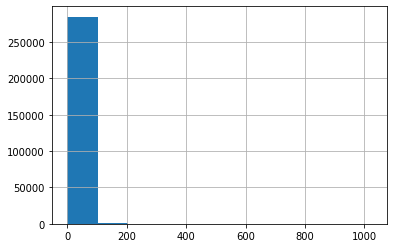

In [282]:
df_train_label.hist()

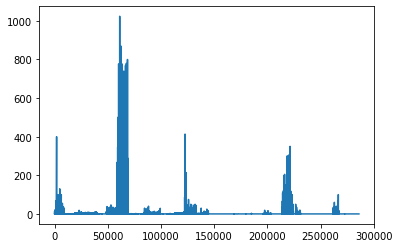

In [283]:
df_train_label.plot()

In [284]:
df_valid=df_valid_raw.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_valid_label=df_valid['last_sale_price'].copy()
df_valid_processed=preprocessing.transform(df_valid)
df_valid_processed.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)
df_valid_processed

starting categorical feature with input shape: (23910, 33)
starting feature with input shape: (23910, 33)
starting avg price feature with input shape: (23910, 37)


,last_sale_price_shelf_life_avg,last_sale_price_avg,last_sale_price_year_avg,last_sale_price_month_avg,shelf_duration,openrarity_ratio,last_sale_date_year,last_sale_date_month,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,Unnamed: 0_y,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,1.511356,1.646896,2.100433,2.113628,7,NaN,2022,11,21928,0,49,2.000000,NaN,NaN,NaN,202211,1,202204,1,2,1,1000.0,250,False,False,True,True,False,39,31,187.967742,8.290323,60.935484,0,0,2,591,28,380
1,1.184682,1.293984,2.100433,1.509980,1,NaN,2022,7,51507,0,30,233.087545,NaN,NaN,NaN,202207,5022,202206,1,8,1,1000.0,250,False,False,True,True,False,23,13,316.692308,50.615385,184.538462,99,9,40,540,121,359
2,3.775820,0.449103,2.100433,0.947284,4,NaN,2022,10,51508,1,30,301.855919,NaN,NaN,NaN,202210,5022,202206,1,8,1,1000.0,250,False,False,True,True,False,23,13,316.692308,50.615385,184.538462,99,9,40,540,121,359
3,2.174629,2.711730,2.100433,2.754010,0,NaN,2022,6,51509,2,30,176.886730,NaN,NaN,NaN,202206,5022,202206,1,8,1,1000.0,250,False,False,True,True,False,23,13,316.692308,50.615385,184.538462,99,9,40,540,121,359
4,2.174629,2.711730,2.100433,2.754010,0,NaN,2022,6,51510,3,30,325.352608,NaN,NaN,NaN,202206,5022,202206,1,8,1,1000.0,250,False,False,True,True,False,23,13,316.692308,50.615385,184.538462,99,9,40,540,121,359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23905,3.775820,1.293984,2.100433,1.509980,4,0.717030,2022,7,215646,8883,37,57.110593,0.918571,6345.0,8849.0,202207,8888,202203,1,8,1,800.0,250,True,False,True,True,True,28,8,76.000000,17.000000,29.750000,0,0,6,155,47,51
23906,3.775820,1.293984,2.100433,1.509980,4,0.590010,2022,7,215647,8884,37,58.689424,0.959838,5221.0,8849.0,202207,8888,202203,1,8,1,800.0,250,True,False,True,True,True,28,8,76.000000,17.000000,29.750000,0,0,6,155,47,51
23907,3.775820,1.293984,2.100433,1.509980,4,0.808114,2022,7,215648,8885,37,55.561696,0.881445,7151.0,8849.0,202207,8888,202203,1,8,1,800.0,250,True,False,True,True,True,28,8,76.000000,17.000000,29.750000,0,0,6,155,47,51
23908,3.775820,1.293984,2.100433,1.509980,4,0.043169,2022,7,215649,8886,37,192.718777,1.237067,382.0,8849.0,202207,8888,202203,1,8,1,800.0,250,True,False,True,True,True,28,8,76.000000,17.000000,29.750000,0,0,6,155,47,51


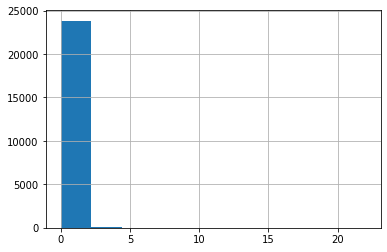

In [285]:
df_valid_label.hist()

In [286]:
df_train_all_merged=df_all_train.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_all_merged_label=df_train_all_merged['last_sale_price'].copy()
#df_train_all_merged.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)

In [287]:
df_train_all_processed=df_all_train.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_all_processed_label=df_train_all_processed['last_sale_price'].copy()
#df_train_all_processed.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)
#df_train_all_processed=preprocessing_all.fit_transform(df_train_all_processed.copy())
#df_train_all_processed

In [288]:
df_valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23910 entries, 0 to 23909
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   last_sale_price_shelf_life_avg  23902 non-null  float64
 1   last_sale_price_avg             23910 non-null  float64
 2   last_sale_price_year_avg        23910 non-null  float64
 3   last_sale_price_month_avg       23910 non-null  float64
 4   shelf_duration                  23910 non-null  int32  
 5   openrarity_ratio                18887 non-null  float64
 6   last_sale_date_year             23910 non-null  int32  
 7   last_sale_date_month            23910 non-null  int32  
 8   global_index                    23910 non-null  int64  
 9   nft_id                          23910 non-null  int64  
 10  collection_id                   23910 non-null  int64  
 11  rarity_score                    23910 non-null  float64
 12  openrarity_score                

In [289]:
df_valid_processed[all_column_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23910 entries, 0 to 23909
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   rarity_score                    23910 non-null  float64
 1   openrarity_score                18887 non-null  float64
 2   openrarity_rank                 18887 non-null  float64
 3   openrarity_max_rank             18887 non-null  float64
 4   total_supply                    23910 non-null  int64  
 5   n_of_traits                     23910 non-null  int64  
 6   seller_fees                     23910 non-null  float64
 7   platform_fees                   23910 non-null  int64  
 8   n_tweets_in_range               23910 non-null  int64  
 9   avg_likes                       23910 non-null  float64
 10  avg_replies                     23910 non-null  float64
 11  avg_retweets                    23910 non-null  float64
 12  min_likes                       

In [290]:
df_train_processed[all_column_names]

,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,total_supply,n_of_traits,seller_fees,platform_fees,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,shelf_duration,openrarity_ratio,last_sale_date_year,last_sale_date_month,last_sale_price_shelf_life_avg,last_sale_price_avg,last_sale_price_year_avg,last_sale_price_month_avg,verification_status,contract_type,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,creation_date,last_sale_date
0,97.077216,NaN,NaN,NaN,8888,5,500.0,250,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1,NaN,2021,8,1.184682,5.844698,3.513175,1.493149,1,1,False,False,True,True,False,202107,202108
1,139.453086,NaN,NaN,NaN,8888,5,500.0,250,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,101,NaN,2022,8,4.838060,0.656716,2.100433,1.493149,1,1,False,False,True,True,False,202107,202208
2,127.753445,NaN,NaN,NaN,8888,5,500.0,250,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1,NaN,2021,8,1.184682,5.844698,3.513175,1.493149,1,1,False,False,True,True,False,202107,202108
3,112.315719,NaN,NaN,NaN,8888,5,500.0,250,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,102,NaN,2022,9,1.734993,0.497560,2.100433,0.982954,1,1,False,False,True,True,False,202107,202209
4,179.395901,NaN,NaN,NaN,8888,5,500.0,250,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1,NaN,2021,8,1.184682,5.844698,3.513175,1.493149,1,1,False,False,True,True,False,202107,202108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285995,128.268841,NaN,NaN,NaN,9000,8,900.0,250,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,NaN,2022,8,1.114488,0.656716,2.100433,1.493149,0,0,False,False,True,False,False,202202,202208
285996,152.040769,NaN,NaN,NaN,9000,8,900.0,250,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,NaN,2022,8,1.114488,0.656716,2.100433,1.493149,0,0,False,False,True,False,False,202202,202208
285997,178.734807,NaN,NaN,NaN,9000,8,900.0,250,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,NaN,2022,8,1.114488,0.656716,2.100433,1.493149,0,0,False,False,True,False,False,202202,202208
285998,130.974464,NaN,NaN,NaN,9000,8,900.0,250,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,NaN,2022,8,1.114488,0.656716,2.100433,1.493149,0,0,False,False,True,False,False,202202,202208


In [291]:
df_valid_processed[all_column_names]

,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,total_supply,n_of_traits,seller_fees,platform_fees,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,shelf_duration,openrarity_ratio,last_sale_date_year,last_sale_date_month,last_sale_price_shelf_life_avg,last_sale_price_avg,last_sale_price_year_avg,last_sale_price_month_avg,verification_status,contract_type,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,creation_date,last_sale_date
0,2.000000,NaN,NaN,NaN,1,2,1000.0,250,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,7,NaN,2022,11,1.511356,1.646896,2.100433,2.113628,1,1,False,False,True,True,False,202204,202211
1,233.087545,NaN,NaN,NaN,5022,8,1000.0,250,13,316.692308,50.615385,184.538462,99,9,40,540,121,359,1,NaN,2022,7,1.184682,1.293984,2.100433,1.509980,1,1,False,False,True,True,False,202206,202207
2,301.855919,NaN,NaN,NaN,5022,8,1000.0,250,13,316.692308,50.615385,184.538462,99,9,40,540,121,359,4,NaN,2022,10,3.775820,0.449103,2.100433,0.947284,1,1,False,False,True,True,False,202206,202210
3,176.886730,NaN,NaN,NaN,5022,8,1000.0,250,13,316.692308,50.615385,184.538462,99,9,40,540,121,359,0,NaN,2022,6,2.174629,2.711730,2.100433,2.754010,1,1,False,False,True,True,False,202206,202206
4,325.352608,NaN,NaN,NaN,5022,8,1000.0,250,13,316.692308,50.615385,184.538462,99,9,40,540,121,359,0,NaN,2022,6,2.174629,2.711730,2.100433,2.754010,1,1,False,False,True,True,False,202206,202206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23905,57.110593,0.918571,6345.0,8849.0,8888,8,800.0,250,8,76.000000,17.000000,29.750000,0,0,6,155,47,51,4,0.717030,2022,7,3.775820,1.293984,2.100433,1.509980,1,1,True,False,True,True,True,202203,202207
23906,58.689424,0.959838,5221.0,8849.0,8888,8,800.0,250,8,76.000000,17.000000,29.750000,0,0,6,155,47,51,4,0.590010,2022,7,3.775820,1.293984,2.100433,1.509980,1,1,True,False,True,True,True,202203,202207
23907,55.561696,0.881445,7151.0,8849.0,8888,8,800.0,250,8,76.000000,17.000000,29.750000,0,0,6,155,47,51,4,0.808114,2022,7,3.775820,1.293984,2.100433,1.509980,1,1,True,False,True,True,True,202203,202207
23908,192.718777,1.237067,382.0,8849.0,8888,8,800.0,250,8,76.000000,17.000000,29.750000,0,0,6,155,47,51,4,0.043169,2022,7,3.775820,1.293984,2.100433,1.509980,1,1,True,False,True,True,True,202203,202207


In [292]:
df_train_processed[all_column_names].apply(lambda x: x.unique())

rarity_score                      [97.07721623225166, 139.45308602172497, 127.75...
openrarity_score                  [nan, 0.986535021319271, 1.003833199964582, 0....
openrarity_rank                   [nan, 5814.0, 4386.0, 6549.0, 3497.0, 4926.0, ...
openrarity_max_rank                [nan, 9928.0, 15555.0, 5555.0, 15000.0, 10000.0]
total_supply                      [8888, 9997, 6501, 12505, 7993, 9998, 5555, 10...
n_of_traits                       [5, 19, 31, 6, 10, 14, 7, 13, 12, 1, 4, 8, 9, ...
seller_fees                       [500.0, 750.0, 1000.0, 800.0, 250.0, nan, 900....
platform_fees                                                                 [250]
n_tweets_in_range                 [11, 19, 2, 3, 18, 35, 12, 4, 151, 16, 40, 6, ...
avg_likes                         [133.1818181818182, 0.0, 183.0, 6.666666666666...
avg_replies                       [13.454545454545457, 0.0, 8.5, 1.6666666666666...
avg_retweets                      [55.18181818181818, 8.947368421052632, 41.

In [293]:
df_train_label.describe()

count    2.860000e+05
mean     2.324017e+00
std      1.326030e+01
min      6.485360e-08
25%      4.006058e-03
50%      7.951988e-03
75%      3.397104e-01
max      1.024002e+03
Name: last_sale_price, dtype: float64

In [294]:
df_train_all_processed_label.describe()

count    3.099100e+05
mean     2.162269e+00
std      1.275132e+01
min      6.485360e-08
25%      4.077085e-03
50%      8.103344e-03
75%      3.252062e-01
max      1.024002e+03
Name: last_sale_price, dtype: float64

In [295]:
df_valid_label.describe()

count    2.391000e+04
mean     2.275248e-01
std      4.202925e-01
min      3.374680e-07
25%      5.265797e-03
50%      7.364013e-02
75%      2.808333e-01
max      2.200320e+01
Name: last_sale_price, dtype: float64

In [296]:
df_valid_processed[all_column_names].apply(lambda x: x.unique())

rarity_score                      [2.0, 233.08754510852737, 301.8559194575652, 1...
openrarity_score                  [nan, 0.845854681585512, 0.922150504780118, 1....
openrarity_rank                   [nan, 9532.0, 6731.0, 2395.0, 2525.0, 217.0, 8...
openrarity_max_rank                                           [nan, 9999.0, 8849.0]
total_supply                                                  [1, 5022, 9999, 8888]
n_of_traits                                                                  [2, 8]
seller_fees                                                         [1000.0, 800.0]
platform_fees                                                                 [250]
n_tweets_in_range                                                    [31, 13, 3, 8]
avg_likes                         [187.96774193548387, 316.6923076923077, 227.33...
avg_replies                       [8.290322580645162, 50.61538461538461, 61.3333...
avg_retweets                      [60.935483870967744, 184.53846153846155, 1

In [297]:
df_train_label

0         1.200357
1         3.180572
2         3.502910
3         4.009567
4         2.001691
            ...   
285995    0.001571
285996    0.001661
285997    0.008480
285998    0.004236
285999    0.006236
Name: last_sale_price, Length: 286000, dtype: float64

# Model Training with LightGBM and DART

In [298]:
def exp_rmse_score(y_true, y_hat):        
    
    rmse=mean_squared_error (y_true, y_hat, squared=False)    
    res=np.exp(-rmse/10)
    return res

def lgb_exp_rmse_score(y_true, y_hat):        

    res=exp_rmse_score(y_true,y_hat)
    #print(f"res: {res}")
    return 'exp_rmse', res, True

In [299]:
def create_catboost_regressor(num_iter=1000):    
    params = {
        'iterations':num_iter, 
        'objective':'RMSE',
        #'max_depth':6, 
        'learning_rate':0.9, 
        'loss_function':'RMSE',
        'min_data_in_leaf':100,
        'early_stopping_rounds':50,
        #'eval_metric':exp_rmse_score,
        #'score_function':[exp_rmse_score],
        'verbose':1
    } 
    
    lgb_valid = [(df_train_processed[all_column_names],df_train_label),
                (df_valid_processed[all_column_names],df_valid_label)]
    fit_params={'regressior__eval_set':lgb_valid,                
                #'regressior__feature_name':all_column_names,
                'regressior__cat_features':cat_features,
                'regressior__verbose':1
               }
 
    regressor= Pipeline([#('preprocessing', preprocessing),                                               
                         ('regressior',CatBoostRegressor(**params))],
                        verbose=False)                      
    return regressor, fit_params

In [328]:
def create_lgb_regressor(num_iter=1000):    
    params = {
        'force_col_wise':True, # memory foot print is smaller
        'n_estimators':num_iter,
        'objective': 'regression',
        'metric': "rmse",
        #'metric':[lgb_exp_rmse_score],
        #'boosting_type': 'dart',
        'max_depth' : -1,
        'random_state': MY_SEED,        
        'learning_rate': 0.01,
        #'num_leaves': 2 ** 6, 
        'min_data_in_leaf': 50,
        #'subsample': 0.8,  
        #'subsample_freq': 1,
        #'first_metric_only': True,
        #'boost_from_average': False,
        #'tree_learner': 'serial',        
        'verbose': 2,      
    }   

    fit_params={'regressior__feature_name':all_column_names,
                'regressior__eval_metric':[lgb_exp_rmse_score],
                'regressior__categorical_feature':cat_features,
                'regressior__verbose':2
               }

    regressor= Pipeline([#('preprocessing', preprocessing),                      
                         ('regressior',lgb.LGBMRegressor())]  ,                       
                        verbose=False)                      
    return regressor, fit_params

In [329]:
df_train_all_merged.columns

Index(['global_index', 'nft_id', 'collection_id', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'last_sale_date', 'last_sale_price', 'Unnamed: 0_x', 'total_supply', 'creation_date', 'verification_status', 'n_of_traits', 'contract_type', 'seller_fees', 'platform_fees', 'openrarity_enabled', 'has_website', 'has_own_twitter', 'has_discord', 'has_medium', 'Unnamed: 0_y', 'n_tweets_in_range', 'avg_likes', 'avg_replies', 'avg_retweets', 'min_likes', 'min_replies', 'min_retweets', 'max_likes', 'max_replies', 'max_retweets'], dtype='object')

In [330]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
# CV 
def apply_cross_validation(num_iter=100,cv=5):
    seed_everything()
    #regressor, fit_params=create_lgb_regressor(num_iter)
    #regressor, fit_params=create_catboost_regressor(num_iter)
        
    col_ids=df_train_all_merged.collection_id.unique()
    print(f"col_ids: {col_ids}")
    pred_results=np.zeros(len(df_train_all_merged))
    pred_true=np.zeros(len(df_train_all_merged))
    
    res=None
    kf = KFold(n_splits=cv, shuffle=True, random_state=MY_SEED)
    for i, (train_index, test_index) in enumerate(kf.split(col_ids)):            
      print(f"Fold {i}: train collections: {col_ids[train_index]} test collections: {col_ids[test_index]}")
      train_col_ids=df_train_all_merged.collection_id.isin(col_ids[train_index])
      test_col_ids=df_train_all_merged.collection_id.isin(col_ids[test_index])
      #print(f"test_col_ids: {test_col_ids}")
      df_train_processed=df_train_all_merged[train_col_ids].copy()     
      df_train_processed_label=df_train_all_merged_label[train_col_ids]
      df_valid_processed=df_train_all_merged[test_col_ids].copy()
      df_valid_processed_label=df_train_all_merged_label[test_col_ids]
      
      preprocessing=createPreprocessing()
      df_train_processed=preprocessing.fit_transform(df_train_processed)
      df_valid_processed=preprocessing.transform(df_valid_processed)


      regressor, fit_params=create_lgb_regressor(num_iter)
      #regressor, fit_params=create_catboost_regressor(num_iter)

      lgb_valid = [(df_train_processed[all_column_names],df_train_processed_label),
                  (df_valid_processed[all_column_names],df_valid_processed_label)]
      fit_params['regressior__eval_set']=lgb_valid   

      regressor=regressor.fit(df_train_processed[all_column_names], df_train_processed_label,  **fit_params)  
      predict_hat=regressor.predict(df_valid_processed[all_column_names])
      pred_results[test_col_ids]=predict_hat
      pred_true[test_col_ids]=df_valid_processed_label[test_col_ids]

      scr=exp_rmse_score(df_valid_processed_label[test_col_ids],predict_hat)
      #scr=exp_rmse_score(df_valid_processed_label[test_col_ids],df_valid_processed_label[test_col_ids])
      print(f" fold: {i} exp_rmse_score: {scr}")

    final_scr=exp_rmse_score(pred_true, pred_results)
    print(f" final exp_rmse_score: {final_scr}")

    #res=cross_validate(regressor,df_train[all_column_names],df_train_label,  fit_params=fit_params,scoring=make_scorer(exp_rmse_score), cv=cv, verbose=1)    
    #res=cross_val_score(regressor,df_train_processed[all_column_names],df_train_label,  fit_params=fit_params, scoring=make_scorer(exp_rmse_score, greater_is_better=True), cv=cv)    
    return regressor, pred_results, pred_true, final_scr

regressor,pred_results, pred_true, final_scr=apply_cross_validation(num_iter=100,cv=5)
final_scr

col_ids: [49 45 54 30  0 58 15 23  7 38 31 50 37  1  8 57 59 19  6 48 14 36 25 13
 43 18 60 44 24 51 46 34 26  4]
Fold 0: train collections: [49 45 54 30  0 58 15 23 38 31 50 37  1  8 59 19  6 14 25 13 18 24 51 46
 34 26  4] test collections: [ 7 57 48 36 43 60 44]
starting categorical feature with input shape: (249103, 33)
[Pipeline]  (step 1 of 3) Processing categoricaltransformer, total=   0.1s
starting feature with input shape: (249103, 33)
[Pipeline]  (step 2 of 3) Processing featuretransformers, total=   0.0s
starting avg price feature with input shape: (249103, 37)
[Pipeline]  (step 3 of 3) Processing avgpricetransformer, total=   0.5s
starting categorical feature with input shape: (60807, 33)
starting feature with input shape: (60807, 33)
starting avg price feature with input shape: (60807, 37)


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1208: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contract_type', 'creation_date', 'has_discord', 'has_medium', 'has_own_twitter', 'has_website', 'last_sale_date', 'openrarity_enabled', 'verification_status']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


 fold: 0 exp_rmse_score: 0.0588309648619653
Fold 1: train collections: [45 54 30 58 15 23  7 31 50  1  8 57  6 48 14 36 25 13 43 18 60 44 24 51
 46 34  4] test collections: [49  0 38 37 59 19 26]
starting categorical feature with input shape: (268457, 33)
[Pipeline]  (step 1 of 3) Processing categoricaltransformer, total=   0.2s
starting feature with input shape: (268457, 33)
[Pipeline]  (step 2 of 3) Processing featuretransformers, total=   0.0s
starting avg price feature with input shape: (268457, 37)
[Pipeline]  (step 3 of 3) Processing avgpricetransformer, total=   0.5s
starting categorical feature with input shape: (41453, 33)
starting feature with input shape: (41453, 33)
starting avg price feature with input shape: (41453, 37)


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1208: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contract_type', 'creation_date', 'has_discord', 'has_medium', 'has_own_twitter', 'has_website', 'last_sale_date', 'openrarity_enabled', 'verification_status']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


 fold: 1 exp_rmse_score: 0.3799193300808581
Fold 2: train collections: [49  0 15 23  7 38 31 37  8 57 59 19  6 48 14 36 25 13 43 18 60 44 24 51
 34 26  4] test collections: [45 54 30 58 50  1 46]
starting categorical feature with input shape: (215619, 33)
[Pipeline]  (step 1 of 3) Processing categoricaltransformer, total=   0.1s
starting feature with input shape: (215619, 33)
[Pipeline]  (step 2 of 3) Processing featuretransformers, total=   0.0s
starting avg price feature with input shape: (215619, 37)
[Pipeline]  (step 3 of 3) Processing avgpricetransformer, total=   0.4s
starting categorical feature with input shape: (94291, 33)
starting feature with input shape: (94291, 33)
starting avg price feature with input shape: (94291, 37)


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1208: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contract_type', 'creation_date', 'has_discord', 'has_medium', 'has_own_twitter', 'has_website', 'last_sale_date', 'openrarity_enabled', 'verification_status']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


 fold: 2 exp_rmse_score: 0.017039243987830636
Fold 3: train collections: [49 45 54 30  0 58 23  7 38 31 50 37  1  8 57 59 19 48 14 36 43 60 44 24
 46 26  4] test collections: [15  6 25 13 18 51 34]
starting categorical feature with input shape: (244683, 33)
[Pipeline]  (step 1 of 3) Processing categoricaltransformer, total=   0.1s
starting feature with input shape: (244683, 33)
[Pipeline]  (step 2 of 3) Processing featuretransformers, total=   0.0s
starting avg price feature with input shape: (244683, 37)
[Pipeline]  (step 3 of 3) Processing avgpricetransformer, total=   0.4s
starting categorical feature with input shape: (65227, 33)
starting feature with input shape: (65227, 33)
starting avg price feature with input shape: (65227, 37)


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1208: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contract_type', 'creation_date', 'has_discord', 'has_medium', 'has_own_twitter', 'has_website', 'last_sale_date', 'openrarity_enabled', 'verification_status']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


 fold: 3 exp_rmse_score: 0.744917188509883
Fold 4: train collections: [49 45 54 30  0 58 15  7 38 50 37  1 57 59 19  6 48 36 25 13 43 18 60 44
 51 46 34 26] test collections: [23 31  8 14 24  4]
starting categorical feature with input shape: (261778, 33)
[Pipeline]  (step 1 of 3) Processing categoricaltransformer, total=   0.1s
starting feature with input shape: (261778, 33)
[Pipeline]  (step 2 of 3) Processing featuretransformers, total=   0.0s
starting avg price feature with input shape: (261778, 37)
[Pipeline]  (step 3 of 3) Processing avgpricetransformer, total=   0.4s
starting categorical feature with input shape: (48132, 33)
starting feature with input shape: (48132, 33)
starting avg price feature with input shape: (48132, 37)


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1208: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contract_type', 'creation_date', 'has_discord', 'has_medium', 'has_own_twitter', 'has_website', 'last_sale_date', 'openrarity_enabled', 'verification_status']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


 fold: 4 exp_rmse_score: 0.846371268079942
 final exp_rmse_score: 0.07415719137977449


0.07415719137977449

In [ ]:
exp_rmse_score(res.shape

In [ ]:
np.exp(-5.55/10)

#Run Regressor on the test validation set

In [ ]:

def run_test_validation(num_iter=100):
    seed_everything()
    regressor, fit_params=create_lgb_regressor(num_iter)
    #regressor, fit_params=create_catboost_regressor(num_iter)
    
    eval_set = [(df_train_processed[all_column_names],df_train_label),
                (df_valid_processed[all_column_names],df_valid_label)]
    fit_params['regressior__eval_set']=eval_set

    print(f"Applying num_iter: {num_iter} ")
    res=regressor.fit(df_train_processed[all_column_names],df_train_label,  **fit_params)    
    return regressor,res

regressor,res=run_test_validation(num_iter=1000)
res

In [ ]:
np.exp(-23.3482362/10)

In [ ]:
def run_all_train(num_iter=100):
    seed_everything()
    #regressor=create_regressor(num_iter)
    regressor=create_catboost_regressor(num_iter)
    
    eval_set = [(df_train_all_processed[all_column_names],df_train_all_processed_label)]
    fit_params={'regressior__eval_set':None, 
                #'regressior__eval_metric':[lgb_exp_rmse_score],
                #'regressior__feature_name':all_column_names,
                'regressior__cat_features':cat_features,
                'regressior__verbose':1
               }
    print(f"Applying num_iter: {num_iter} ")
    res=regressor.fit(df_train_all_processed[all_column_names],df_train_all_processed_label,  **fit_params)    
    return regressor,res

regressor,res=run_all_train(num_iter=1000)
res



In [ ]:
df_train_all_processed[num_features]